# Evaluate Effect of Step Size and Method Choice
We are going to establish the effect of displacement step size and quantum chemistry method on the accuracy of vibrational properties.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from ase.thermochemistry import IdealGasThermo
from ase.vibrations import VibrationsData, Vibrations
from jitterbug.compare import compare_hessians
from dataclasses import asdict
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import shutil
import json
import os

Configure

In [2]:
molecule_name = 'water'  # Which water molecule to evaluate
target_method = ('ccsd(t)', 'cc-pvtz')

## Load in Target Hessians
We have it in a JSON file from PubChem

In [3]:
hessian_paths = list(Path('data/exact/').glob(f'{molecule_name}_*-ase.json'))
print(f'Found {len(hessian_paths)} hessians for {molecule_name}')

Found 31 hessians for water


In [4]:
exact_path = Path(f'data/exact/{molecule_name}_{"_".join(target_method)}_d=0.005-ase.json')
assert exact_path.exists(), f'Missing reference calculation: {exact_path}'
exact_hess = VibrationsData.read(exact_path)

In [5]:
def load_hessian(path: Path):
    """Load the Hessian and parse the metadata from the filename
    
    Args:
        path: Path to the Hessia
    Returns:
        Dictionary the includes the metadata for the calculation and errors wrt true Hessian
    """
    
    # Get some of the basic information
    method_name, delta = path.name[:-9].rsplit("_d=", 1)
    delta = float(delta)
    _, method, basis = method_name.split("_")
    
    # Compare to reference
    approx_hess = VibrationsData.read(path)
    compare = compare_hessians(exact_hess.get_atoms(), exact_hess.get_hessian_2d(), approx_hess.get_hessian_2d(), scale_factor=1.)
    
    return {
        'method': method,
        'basis': basis,
        'title': (method + '//' + basis if basis != "None" else method),
        'delta': delta,
        'path': path,
        **asdict(compare)
    }

In [6]:
all_hessians = pd.DataFrame(load_hessian(p) for p in hessian_paths)
print(f'Loaded comparisons from {len(all_hessians)} Hessians')

/home/lward/miniconda3/envs/jitterbug/lib/python3.9/site-packages/pmutt/statmech/vib.py:87: RuntimeWarning: overflow encountered in sinh
  (0.5 * vib_dimless)**2 * (1. / np.sinh(vib_dimless / 2.))**2


Loaded comparisons from 31 Hessians


## Summarize Methods

Order the methods by best ZPE

In [7]:
all_hessians['zpe_error_abs'] = all_hessians['zpe_error'].abs()

In [8]:
sorted_methods = all_hessians.groupby('title')['zpe_error_abs'].min().sort_values().reset_index()
sorted_methods.iloc[1:]

,title,zpe_error_abs
1,m062x//cc-pvtz,0.018366
2,wb97x-d//cc-pvtz,0.019518
3,ccsd(t)//cc-pvdz,0.041130
4,b3lyp//cc-pvtz,0.060601
5,hf//cc-pvtz,0.834580
6,pm7,3.282223


In [9]:
method_order = sorted_methods['title'][1:]

## Plot Performance
Use a heatmap

In [10]:
def assemble_heatmap(col_name: str) -> tuple[np.ndarray, list[str]]:
    """Assemble the data needed for a heatmap
    
    Args:
        Name of column to be plotted
    Returns:
        Data used for the plot
    """
    
    # Make sure all methods have the same deltas
    deltas = all_hessians.query(f'title != "ccsd(t)//cc-pvtz"').sort_values('delta').groupby('title')['delta'].apply(list)
    assert all(deltas[0] == d for d in deltas), deltas
    
    
    return np.array([
        all_hessians.query(f'title == "{method}"').sort_values('delta')[col_name].tolist()
        for method in method_order
    ]), [str(x) for x in deltas[0]]

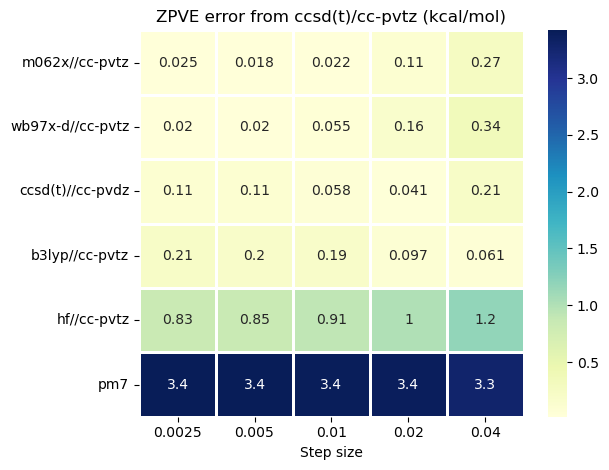

In [11]:
fig, ax = plt.subplots()

zpe_accuracy, xticklabels = assemble_heatmap('zpe_error_abs')
ax = sns.heatmap(zpe_accuracy, cmap="YlGnBu", linewidth=1, annot=True, yticklabels=method_order, xticklabels=xticklabels, ax=ax)
ax.set_title(f'ZPVE error from {"/".join(target_method)} (kcal/mol)')
ax.set_xlabel('Step size')

fig.tight_layout()

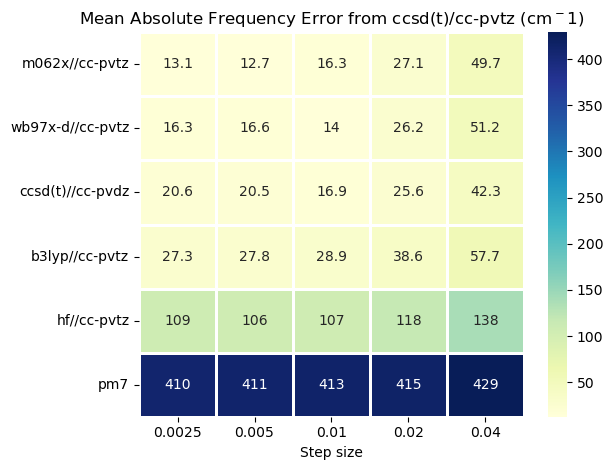

In [12]:
fig, ax = plt.subplots()

zpe_accuracy, xticklabels = assemble_heatmap('vib_mae')
ax = sns.heatmap(zpe_accuracy, cmap="YlGnBu", linewidth=1, annot=True, fmt='.3g', yticklabels=method_order, xticklabels=xticklabels, ax=ax)
ax.set_title(f'Mean Absolute Frequency Error from {"/".join(target_method)} (cm$^{-1}$)')
ax.set_xlabel('Step size')

fig.tight_layout()